In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# Load the JSON data into a DataFrame
df = pd.read_json('./poetryData/poetry_issues_all.json')

# Function to extract the kind value from the 'labels' list.
def extract_kind(labels):
    if isinstance(labels, list):
        # Look for a label that starts with 'kind/'
        for lab in labels:
            if lab.startswith('kind/'):
                # Return everything after "kind/"
                return lab.split('kind/')[1]
    return 'unknown'

# Function to determine if the 'reopened' event label is present.
def check_reopened(row):
    # Access the events from the row if present, else default to an empty list.
    events = row.get('events', [])
    if isinstance(events, list):
        for event in events:
            if event.get('event_type') == 'reopened':
                return 1
    return 0

# Create new data frame for the 'kind' and reopened.
df['kind'] = df['labels'].apply(extract_kind)
df['reopened'] = df.apply(check_reopened, axis=1)

# Ensure 'kind' columns are strings
df['kind'] = df['kind'].astype(str)

# Apply LabelEncoder to 'kind' and 'state' columns
label_encoder = LabelEncoder()
df['kind_encoded'] = label_encoder.fit_transform(df['kind'])

# Create a legend for 'kind' labels
kind_legend = dict(enumerate(label_encoder.classes_))
print("Kind Legend:")
for key, value in kind_legend.items():
    print(f"{key}: {value}")

# Build the  DataFrame with the selected columns: kind, state, text_length, time_diff_min, and reopened.
new_df = df[['kind_encoded', 'reopened']]

# Display the first few rows of the  DataFrame
print( new_df.head())

Kind Legend:
0: bug
1: enhancement
2: feature
3: question
4: refactor
5: release
6: unknown
   kind_encoded  reopened
0             0         0
1             6         0
2             0         0
3             0         0
4             0         0


In [3]:
# Update predictors to use the encoded columns
predictor = new_df[['kind_encoded']]
target = new_df['reopened']

# Split and test the dataset
X_train, X_test, y_train, y_test = train_test_split(
    predictor, target,
    test_size=1/3, random_state=42
)

In [4]:
# Model: RandomForestClassifier
model = RandomForestClassifier(random_state=42)
# model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predictions, evaluation, and score
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.2f}")

# print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 97.69


/var/folders/c5/7ggt4y8x08x51k993kftgclc0000gn/T/ipykernel_13796/1266303218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['predicted_prob'] = model.predict_proba(new_df[['kind_encoded']])[:, 1]


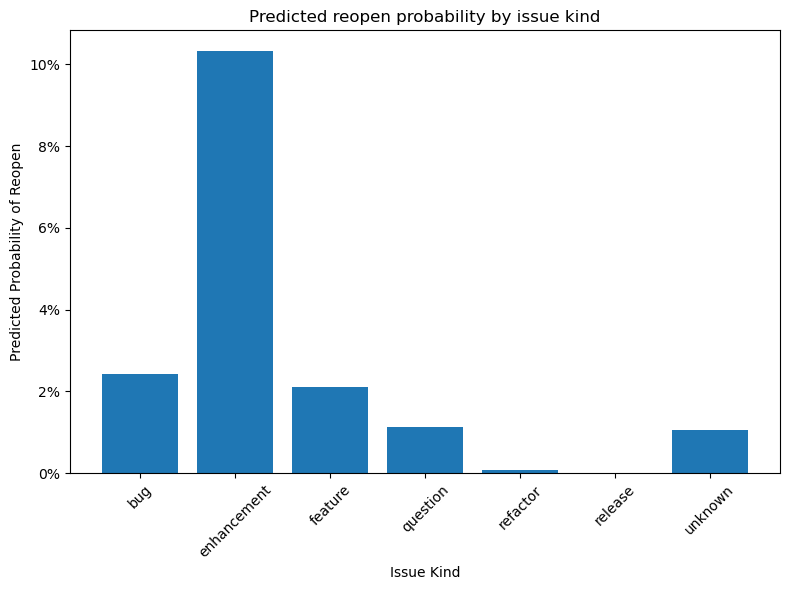

In [5]:
# We compute the predicted probability of reopening for each sample in the full dataset
new_df['predicted_prob'] = model.predict_proba(new_df[['kind_encoded']])[:, 1]

# Group the data by the encoded 'kind' and calculate the average predicted probability
grouped_probs = new_df.groupby('kind_encoded')['predicted_prob'].mean().reset_index()

# Map encoded values to their original kind names
grouped_probs['kind'] = grouped_probs['kind_encoded'].apply(lambda x: kind_legend.get(x, 'unknown'))

# Plot the bar chart using the actual kind names for the x-axis labels
plt.figure(figsize=(8, 6))
plt.bar(grouped_probs['kind'], grouped_probs['predicted_prob'])
plt.xlabel('Issue Kind')
plt.ylabel('Predicted Probability of Reopen')
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: f'{x*100:.0f}%'))
plt.title('Predicted reopen probability by issue kind')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()